<a href="https://colab.research.google.com/github/faizankshaikh/SocialNeuro/blob/main/experiments/RoundRobinVanillaDQN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title Required installation
!pip install -q black gymnasium pettingzoo==1.22.3 tianshou
!git clone https://github.com/faizankshaikh/SocialNeuro

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 816.1/816.1 kB 20.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.1/163.1 kB 16.7 MB/s eta 0:00:00
Cloning into 'SocialNeuro'...
remote: Enumerating objects: 94, done.
remote: Counting objects: 100% (94/94), done.
remote: Compressing objects: 100% (89/89), done.
remote: Total 94 (delta 34), reused 13 (delta 4), pack-reused 0
Receiving objects: 100% (94/94), 32.35 KiB | 517.00 KiB/s, done.
Resolving deltas: 100% (34/34), done.


In [1]:
#@title Change working path
%cd SocialNeuro

/content/SocialNeuro


In [2]:
#@title Import libraries and modules
%load_ext tensorboard

import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from sklearn.preprocessing import MinMaxScaler

from SocialNeuro.envs.social_v0 import SocialNeuro

from torch.optim import Adam
from tianshou.data import Batch
from tianshou.utils.net.common import Net
from tianshou.utils import TensorboardLogger
from tianshou.trainer import offpolicy_trainer
from tianshou.data import Collector, VectorReplayBuffer
from tianshou.env import DummyVectorEnv, PettingZooEnv
from tianshou.policy import BasePolicy, DQNPolicy, MultiAgentPolicyManager

from pettingzoo.utils import parallel_to_aec
from torch.utils.tensorboard import SummaryWriter

In [3]:
#@title Setup environment
env_verbose = SocialNeuro(render_mode="human", cfg_name="comp_v0", reward_struct="egoistic")
env = SocialNeuro(cfg_name="comp_v0", reward_struct="egoistic")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [4]:
#@title Example of gameplay
episodes = 2

for episode in range(episodes):
    print(f"Episode #{episode+1}")
    print("=" * 10)
    obs = env_verbose.reset()
    print()

    while env_verbose.agents:
        acts = {
            "player1": np.random.choice([0, 1]),
            "player2": np.random.choice([0, 1])
        }
        print(f"--Action taken by player 1: {env_verbose.action_dict[acts['player1']]}")
        print(f"--Action taken by player 2: {env_verbose.action_dict[acts['player2']]}")
        print()

        obs, rews, terms, truncs, infos = env_verbose.step(acts)
        print()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Episode #1
--Days left: 2.0
--Current life of agent 1: 2.0
--Current life of agent 2: 3.0
--Individual Probability of payoff: 0.4
--Joint Probability of payoff: 0.64
--Difference in Probability of payoff from the other weather: 0.2
--Forest Index: 4.0
--Weather Index: 0.0

--Action taken by player 1: wait
--Action taken by player 2: wait

--Days left: 1.0
--Current life of agent 1: 1.0
--Current life of agent 2: 2.0
--Previous action of agent 1: wait
--Previous action of agent 2: wait
--Individual Probability of payoff: 0.2
--Joint Probability of payoff: 0.36
--Difference in Probability of payoff from the other weather: -0.2
--Forest Index: 4.0
--Weather Index: 1.0

--Action taken by player 1: play
--Action taken by player 2: play

--Days left: 0.0
--Current life of agent 1: 0.0
--Current life of agent 2: 1.0
--Previous action of agent 1: play
--Previous action of agent 2: play

Episode #2
--Days left: 1.0
--Current life of agent 1: 1.0
--Current life of agent 2: 1.0
--Individual Proba

death rate (in %) of player1: 34.8 +- 5.735
death rate (in %) of player2: 33.5 +- 6.464


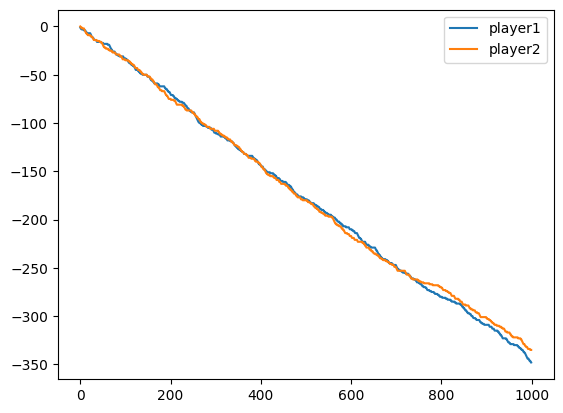

In [5]:
#@title Case - both always cooperate
episodes = 1000

episode_rews = []

for _ in range(episodes):

    obs = env.reset()
    while env.agents:
        acts = {
            "player1": 1,
            "player2": 1
        }

        obs, rews, terms, truncs, infos = env.step(acts)
        # print(obs, rews)

    episode_rews.append([rews['player1'], rews['player2']])

arr = np.array(episode_rews)

interval_size = 100
num_intervals = episodes // interval_size

means = []
std_devs = []

for i in range(0, episodes, interval_size):
    interval_data = arr[i:i+interval_size]
    mean = np.mean(interval_data, axis=0)
    means.append(mean)

for i in range(num_intervals - 1):
    mean_diff = means[i+1] - means[i]
    std_devs.append(mean_diff)

avg = (np.mean(arr, axis=0)) * -100
std_dev = np.std(std_devs, axis=0) * 100

print(f"death rate (in %) of player1: {avg[0]:.1f} +- {std_dev[0]:.3f}")
print(f"death rate (in %) of player2: {avg[1]:.1f} +- {std_dev[1]:.3f}")

plt.plot(arr.cumsum(axis=0))
plt.legend(("player1", "player2"))
plt.show()

death rate (in %) of player1: 49.9 +- 4.140
death rate (in %) of player2: 48.6 +- 5.497


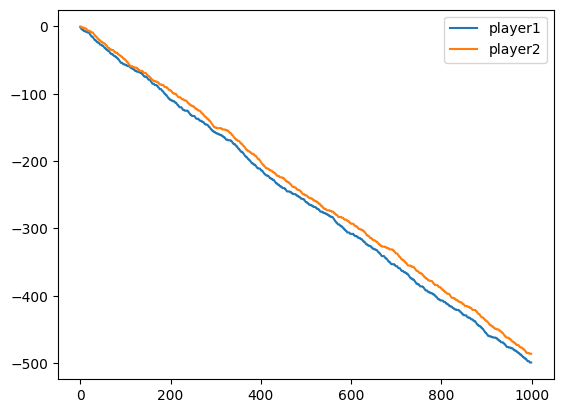

In [6]:
#@title Case - both always defect
episodes = 1000

episode_rews = []

for _ in range(episodes):

    obs = env.reset()
    while env.agents:
        acts = {
            "player1": 0,
            "player2": 0
        }

        obs, rews, terms, truncs, infos = env.step(acts)
        # print(obs, rews)

    episode_rews.append([rews['player1'], rews['player2']])

arr = np.array(episode_rews)
interval_size = 100
num_intervals = episodes // interval_size

means = []
std_devs = []

for i in range(0, episodes, interval_size):
    interval_data = arr[i:i+interval_size]
    mean = np.mean(interval_data, axis=0)
    means.append(mean)

for i in range(num_intervals - 1):
    mean_diff = means[i+1] - means[i]
    std_devs.append(mean_diff)

avg = (np.mean(arr, axis=0)) * -100
std_dev = np.std(std_devs, axis=0) * 100

print(f"death rate (in %) of player1: {avg[0]:.1f} +- {std_dev[0]:.3f}")
print(f"death rate (in %) of player2: {avg[1]:.1f} +- {std_dev[1]:.3f}")
plt.plot(arr.cumsum(axis=0))
plt.legend(("player1", "player2"))
plt.show()

death rate (in %) of player1: 63.1 +- 6.925
death rate (in %) of player2: -0.0 +- 0.000


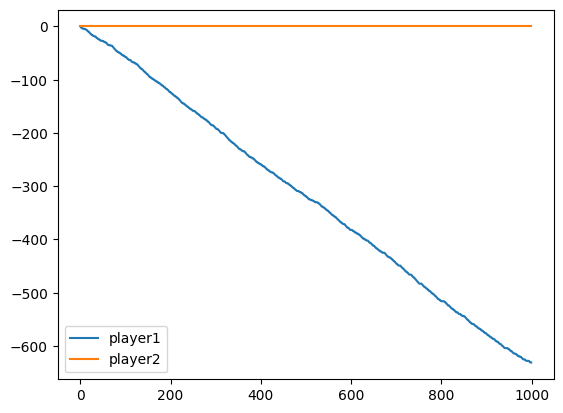

In [7]:
#@title Case - player1 cooperates, player2 defects
episodes = 1000

episode_rews = []

for _ in range(episodes):

    obs = env.reset()
    while env.agents:
        acts = {
            "player1": 1,
            "player2": 0
        }

        obs, rews, terms, truncs, infos = env.step(acts)
        # print(obs, rews)

    episode_rews.append([rews['player1'], rews['player2']])

arr = np.array(episode_rews)
interval_size = 100
num_intervals = episodes // interval_size

means = []
std_devs = []

for i in range(0, episodes, interval_size):
    interval_data = arr[i:i+interval_size]
    mean = np.mean(interval_data, axis=0)
    means.append(mean)

for i in range(num_intervals - 1):
    mean_diff = means[i+1] - means[i]
    std_devs.append(mean_diff)

avg = (np.mean(arr, axis=0)) * -100
std_dev = np.std(std_devs, axis=0) * 100

print(f"death rate (in %) of player1: {avg[0]:.1f} +- {std_dev[0]:.3f}")
print(f"death rate (in %) of player2: {avg[1]:.1f} +- {std_dev[1]:.3f}")
plt.plot(arr.cumsum(axis=0))
plt.legend(("player1", "player2"))
plt.show()

death rate (in %) of player1: 48.6 +- 7.757
death rate (in %) of player2: 14.7 +- 8.625


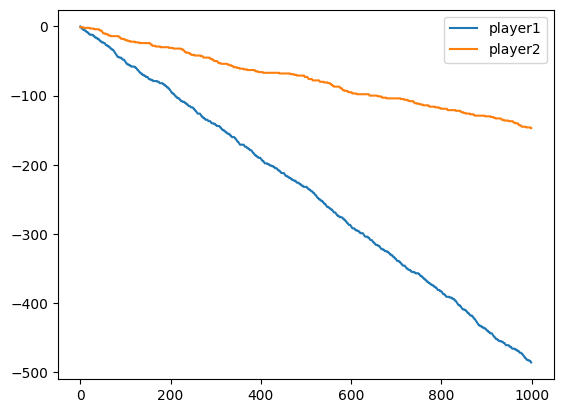

In [8]:
#@title Case - Always cooperate vs random agent
episodes = 1000

episode_rews = []

for _ in range(episodes):

    obs = env.reset()
    while env.agents:
        acts = {
            "player1": 1,
            "player2": np.random.choice([0, 1])
        }

        obs, rews, terms, truncs, infos = env.step(acts)
        # print(obs, rews)

    episode_rews.append([rews['player1'], rews['player2']])

arr = np.array(episode_rews)
interval_size = 100
num_intervals = episodes // interval_size

means = []
std_devs = []

for i in range(0, episodes, interval_size):
    interval_data = arr[i:i+interval_size]
    mean = np.mean(interval_data, axis=0)
    means.append(mean)

for i in range(num_intervals - 1):
    mean_diff = means[i+1] - means[i]
    std_devs.append(mean_diff)

avg = (np.mean(arr, axis=0)) * -100
std_dev = np.std(std_devs, axis=0) * 100

print(f"death rate (in %) of player1: {avg[0]:.1f} +- {std_dev[0]:.3f}")
print(f"death rate (in %) of player2: {avg[1]:.1f} +- {std_dev[1]:.3f}")
plt.plot(arr.cumsum(axis=0))
plt.legend(("player1", "player2"))
plt.show()

death rate (in %) of player1: 20.8 +- 1.853
death rate (in %) of player2: 60.5 +- 9.068


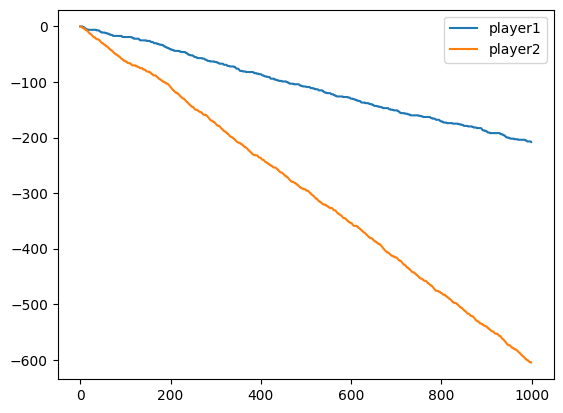

In [9]:
#@title Case - Always defect vs random agent
episodes = 1000

episode_rews = []

for _ in range(episodes):

    obs = env.reset()
    while env.agents:
        acts = {
            "player1": 0,
            "player2": np.random.choice([0, 1])
        }

        obs, rews, terms, truncs, infos = env.step(acts)
        # print(obs, rews)

    episode_rews.append([rews['player1'], rews['player2']])

arr = np.array(episode_rews)
interval_size = 100
num_intervals = episodes // interval_size

means = []
std_devs = []

for i in range(0, episodes, interval_size):
    interval_data = arr[i:i+interval_size]
    mean = np.mean(interval_data, axis=0)
    means.append(mean)

for i in range(num_intervals - 1):
    mean_diff = means[i+1] - means[i]
    std_devs.append(mean_diff)

avg = (np.mean(arr, axis=0)) * -100
std_dev = np.std(std_devs, axis=0) * 100

print(f"death rate (in %) of player1: {avg[0]:.1f} +- {std_dev[0]:.3f}")
print(f"death rate (in %) of player2: {avg[1]:.1f} +- {std_dev[1]:.3f}")
plt.plot(arr.cumsum(axis=0))
plt.legend(("player1", "player2"))
plt.show()

In [10]:
#@title Define heuristic algos in Tianshou
## agent that always plays
class AlwaysPlay(BasePolicy):
    def __init__(self, **kwargs):
        self.nolearn = True
        super().__init__(**kwargs)

    def forward(self, batch, state = None):
        mask = batch.obs.mask
        logits = np.zeros(mask.shape)
        logits[:, 1] = 1
        logits[~mask] = -np.inf
        return Batch(act=logits.argmax(axis=-1))

    def learn(self, batch):
        return {}

## agent that always waits
class AlwaysWait(BasePolicy):
    def __init__(self, **kwargs):
        self.nolearn = True
        super().__init__(**kwargs)

    def forward(self, batch, state = None):
        mask = batch.obs.mask
        logits = np.zeros(mask.shape)
        logits[:, 0] = 1
        logits[~mask] = -np.inf
        return Batch(act=logits.argmax(axis=-1))

    def learn(self, batch):
        return {}

## agent that waits for low health to play
class HailMary(BasePolicy):
    def __init__(self, **kwargs):
        self.nolearn = True
        super().__init__(**kwargs)

    def forward(self, batch, state = None):
        mask = batch.obs.mask
        logits = np.zeros(mask.shape)
        obs = batch.obs.obs

        for i in range(mask.shape[0]):
            if obs[i, :, 2] <= 1:
                logits[i, 1] = 1
            else:
                logits[i, 0] = 1
        logits[~mask] = -np.inf
        return Batch(act=logits.argmax(axis=-1))

    def learn(self, batch):
        return {}

## random agent
class RandomAgent(BasePolicy):
    def __init__(self, **kwargs):
        self.nolearn = True
        super().__init__(**kwargs)

    def forward(self, batch, state = None):
        mask = batch.obs.mask
        logits = np.zeros(mask.shape)
        logits[:, np.random.choice([0, 1])] = 1
        logits[~mask] = -np.inf
        return Batch(act=logits.argmax(axis=-1))

    def learn(self, batch):
        return {}

In [22]:
#@title Prerequisites for training
# Step 2: Wrap the environment for Tianshou interfacing
def _get_env_train():
    env = SocialNeuro(cfg_name="comp_v0", reward_struct="egoistic")
    vec_env = parallel_to_aec(env)
    return PettingZooEnv(vec_env)

def _get_env_test():
    env = SocialNeuro(cfg_name="comp_v0", reward_struct="egoistic")
    vec_env = parallel_to_aec(env)
    return PettingZooEnv(vec_env)

# seed
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

env = SocialNeuro(cfg_name="comp_v0", reward_struct="egoistic")
agents =  env.agents[:]

# Step 3: Define policies for each agent
## learning agent
def _get_agent(pretrained=False):
    vec_env = _get_env_train()
    net = Net(
        state_shape=vec_env.observation_space.shape,
        action_shape=vec_env.action_space.n,
        hidden_sizes=[128, 128],
        # device="cuda",
    )#.to("cuda")
    optim = Adam(net.parameters(), lr=1e-4)
    model = DQNPolicy(
        model=net,
        optim=optim,
        discount_factor=0.9,
        estimation_step=3,
        target_update_freq=50,
    )

    if pretrained:
        model_save_path = os.path.join("models", "vs_hail_mary.pth")
        model.load_state_dict(torch.load(model_save_path))
    return model

agent_learn1 = _get_agent(pretrained=False)
agent_learn2 = _get_agent(pretrained=False)

train_policies = MultiAgentPolicyManager([agent_learn1, agent_learn2],  _get_env_train())

train_envs = DummyVectorEnv([_get_env_train for _ in range(10)])
test_envs = DummyVectorEnv([_get_env_test for _ in range(2)])
train_envs.seed(seed)
test_envs.seed(seed)

# Step 4: Collector setup
train_collector = Collector(
    train_policies,
    train_envs,
    VectorReplayBuffer(20_000, len(train_envs)),
    exploration_noise=True,
)

test_policies = MultiAgentPolicyManager([agent_learn1, agent_learn2],  _get_env_test())
test_collector = Collector(test_policies, test_envs, exploration_noise=True)

train_collector.collect(n_episode=50)

def save_best_fn(policy):
    model_save_path1 = os.path.join("log", "hommul", "dqn", "policy1.pth")
    model_save_path2 = os.path.join("log", "hommul", "dqn", "policy2.pth")
    os.makedirs(os.path.join("log", "hommul", "dqn"), exist_ok=True)
    if not hasattr(train_policies.policies[agents[0]], 'nolearn'):
        torch.save(train_policies.policies[agents[0]].state_dict(), model_save_path1)
    if not hasattr(train_policies.policies[agents[1]], 'nolearn'):
        torch.save(train_policies.policies[agents[1]].state_dict(), model_save_path2)

def stop_fn(mean_rewards):
    return mean_rewards >= 0

def train_fn(epoch, env_step):
    # freeze training for player1
    if not hasattr(train_policies.policies[agents[0]], 'nolearn'):
        train_policies.policies[agents[0]].set_eps(0.05)

    if not hasattr(train_policies.policies[agents[1]], 'nolearn'):
        train_policies.policies[agents[1]].set_eps(0.1)

def test_fn(epoch, env_step):
    if not hasattr(train_policies.policies[agents[0]], 'nolearn'):
        train_policies.policies[agents[0]].set_eps(0.05)

    if not hasattr(train_policies.policies[agents[1]], 'nolearn'):
        train_policies.policies[agents[1]].set_eps(0.05)

def reward_metric(rews):
    return rews[:, 1]


In [23]:
#@title Clear logs and setup TensorBoard
!rm -rf /content/HomMul/log

log_path = os.path.join("log", "hommul", "dqn")
writer = SummaryWriter(log_path)
logger = TensorboardLogger(writer)

#### Evolution 1


Epoch #1: 1001it [00:04, 243.67it/s, env_step=1000, len=2, n/ep=21, n/st=50, player1/loss=0.139, player2/loss=0.172, rew=0.00]                          


Epoch #1: test_reward: -0.020000 ± 0.140000, best_reward: -0.020000 ± 0.140000 in #1


Epoch #2: 1001it [00:04, 245.97it/s, env_step=2000, len=3, n/ep=15, n/st=50, player1/loss=0.178, player2/loss=0.066, rew=0.00]                          


Epoch #2: test_reward: -0.020000 ± 0.140000, best_reward: -0.020000 ± 0.140000 in #1


Epoch #3: 1001it [00:04, 201.07it/s, env_step=3000, len=3, n/ep=19, n/st=50, player1/loss=0.193, player2/loss=0.053, rew=-0.26]                          


Epoch #3: test_reward: -0.140000 ± 0.346987, best_reward: -0.020000 ± 0.140000 in #1


Epoch #4: 1001it [00:03, 253.78it/s, env_step=4000, len=3, n/ep=18, n/st=50, player1/loss=0.173, player2/loss=0.076, rew=-0.39]                          


Epoch #4: test_reward: -0.400000 ± 0.489898, best_reward: -0.020000 ± 0.140000 in #1


Epoch #5: 1001it [00:04, 202.65it/s, env_step=5000, len=3, n/ep=17, n/st=50, player1/loss=0.179, player2/loss=0.120, rew=-0.47]                          


Epoch #5: test_reward: -0.380000 ± 0.485386, best_reward: -0.020000 ± 0.140000 in #1


Epoch #6: 1001it [00:03, 255.14it/s, env_step=6000, len=3, n/ep=16, n/st=50, player1/loss=0.194, player2/loss=0.151, rew=-0.44]                          


Epoch #6: test_reward: -0.380000 ± 0.485386, best_reward: -0.020000 ± 0.140000 in #1


Epoch #7: 1001it [00:03, 253.69it/s, env_step=7000, len=3, n/ep=20, n/st=50, player1/loss=0.181, player2/loss=0.170, rew=-0.35]                          


Epoch #7: test_reward: -0.280000 ± 0.448999, best_reward: -0.020000 ± 0.140000 in #1


Epoch #8: 1001it [00:04, 208.57it/s, env_step=8000, len=2, n/ep=19, n/st=50, player1/loss=0.165, player2/loss=0.166, rew=-0.42]                          


Epoch #8: test_reward: -0.290000 ± 0.453762, best_reward: -0.020000 ± 0.140000 in #1


Epoch #9: 1001it [00:04, 244.19it/s, env_step=9000, len=2, n/ep=23, n/st=50, player1/loss=0.152, player2/loss=0.167, rew=-0.26]                          


Epoch #9: test_reward: -0.310000 ± 0.462493, best_reward: -0.020000 ± 0.140000 in #1


Epoch #10: 1001it [00:05, 193.41it/s, env_step=10000, len=3, n/ep=19, n/st=50, player1/loss=0.149, player2/loss=0.167, rew=-0.47]                          


Epoch #10: test_reward: -0.370000 ± 0.482804, best_reward: -0.020000 ± 0.140000 in #1


Epoch #11: 1001it [00:04, 247.71it/s, env_step=11000, len=2, n/ep=21, n/st=50, player1/loss=0.133, player2/loss=0.185, rew=-0.24]                          


Epoch #11: test_reward: -0.380000 ± 0.485386, best_reward: -0.020000 ± 0.140000 in #1


Epoch #12: 1001it [00:04, 217.45it/s, env_step=12000, len=3, n/ep=21, n/st=50, player1/loss=0.114, player2/loss=0.187, rew=-0.48]                          


Epoch #12: test_reward: -0.350000 ± 0.476970, best_reward: -0.020000 ± 0.140000 in #1


Epoch #13: 1001it [00:05, 197.79it/s, env_step=13000, len=3, n/ep=22, n/st=50, player1/loss=0.116, player2/loss=0.203, rew=-0.41]                          


Epoch #13: test_reward: -0.440000 ± 0.496387, best_reward: -0.020000 ± 0.140000 in #1


Epoch #14: 1001it [00:03, 254.06it/s, env_step=14000, len=3, n/ep=20, n/st=50, player1/loss=0.096, player2/loss=0.204, rew=-0.50]                          


Epoch #14: test_reward: -0.430000 ± 0.495076, best_reward: -0.020000 ± 0.140000 in #1


Epoch #15: 1001it [00:05, 192.69it/s, env_step=15000, len=3, n/ep=22, n/st=50, player1/loss=0.097, player2/loss=0.223, rew=-0.36]                          


Epoch #15: test_reward: -0.460000 ± 0.498397, best_reward: -0.020000 ± 0.140000 in #1


Epoch #16: 1001it [00:03, 251.08it/s, env_step=16000, len=2, n/ep=19, n/st=50, player1/loss=0.085, player2/loss=0.210, rew=-0.47]                          


Epoch #16: test_reward: -0.280000 ± 0.448999, best_reward: -0.020000 ± 0.140000 in #1


Epoch #17: 1001it [00:05, 197.16it/s, env_step=17000, len=2, n/ep=19, n/st=50, player1/loss=0.090, player2/loss=0.216, rew=-0.47]                          


Epoch #17: test_reward: -0.450000 ± 0.497494, best_reward: -0.020000 ± 0.140000 in #1


Epoch #18: 1001it [00:04, 246.68it/s, env_step=18000, len=2, n/ep=23, n/st=50, player1/loss=0.088, player2/loss=0.209, rew=-0.22]                          


Epoch #18: test_reward: -0.420000 ± 0.493559, best_reward: -0.020000 ± 0.140000 in #1


Epoch #19: 1001it [00:03, 251.69it/s, env_step=19000, len=3, n/ep=22, n/st=50, player1/loss=0.078, player2/loss=0.216, rew=-0.27]                          


Epoch #19: test_reward: -0.450000 ± 0.497494, best_reward: -0.020000 ± 0.140000 in #1


Epoch #20: 1001it [00:04, 225.67it/s, env_step=20000, len=2, n/ep=22, n/st=50, player1/loss=0.074, player2/loss=0.223, rew=-0.32]                          


Epoch #20: test_reward: -0.370000 ± 0.482804, best_reward: -0.020000 ± 0.140000 in #1
##########

death rate (in %) of player1: 45.3 +- 6.325
death rate (in %) of player2: 49.0 +- 4.605


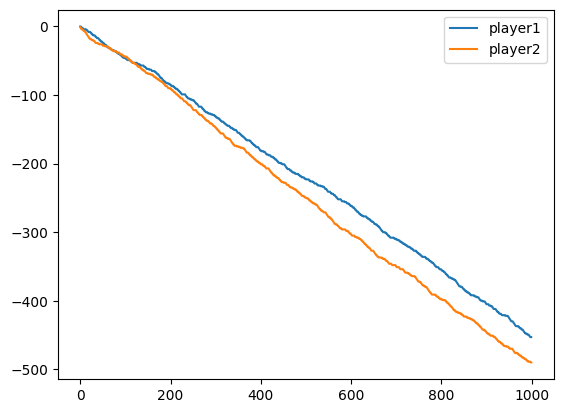


#### Evolution 2


Epoch #1: 1001it [00:04, 243.58it/s, env_step=1000, len=2, n/ep=21, n/st=50, player1/loss=0.126, player2/loss=0.179, rew=-0.19]                          


Epoch #1: test_reward: -0.230000 ± 0.420833, best_reward: -0.230000 ± 0.420833 in #1


Epoch #2: 1001it [00:05, 198.79it/s, env_step=2000, len=3, n/ep=18, n/st=50, player1/loss=0.102, player2/loss=0.180, rew=-0.28]                          


Epoch #2: test_reward: -0.280000 ± 0.448999, best_reward: -0.230000 ± 0.420833 in #1


Epoch #3: 1001it [00:03, 259.79it/s, env_step=3000, len=3, n/ep=17, n/st=50, player1/loss=0.108, player2/loss=0.166, rew=-0.18]                          


Epoch #3: test_reward: -0.330000 ± 0.470213, best_reward: -0.230000 ± 0.420833 in #1


Epoch #4: 1001it [00:04, 237.77it/s, env_step=4000, len=3, n/ep=19, n/st=50, player1/loss=0.108, player2/loss=0.158, rew=-0.47]                          


Epoch #4: test_reward: -0.390000 ± 0.487750, best_reward: -0.230000 ± 0.420833 in #1


Epoch #5: 1001it [00:04, 227.15it/s, env_step=5000, len=3, n/ep=19, n/st=50, player1/loss=0.095, player2/loss=0.150, rew=-0.11]                          


Epoch #5: test_reward: -0.210000 ± 0.407308, best_reward: -0.210000 ± 0.407308 in #5


Epoch #6: 1001it [00:04, 248.85it/s, env_step=6000, len=3, n/ep=21, n/st=50, player1/loss=0.093, player2/loss=0.139, rew=-0.29]                          


Epoch #6: test_reward: -0.350000 ± 0.476970, best_reward: -0.210000 ± 0.407308 in #5


Epoch #7: 1001it [00:05, 199.94it/s, env_step=7000, len=3, n/ep=19, n/st=50, player1/loss=0.103, player2/loss=0.162, rew=-0.58]                          


Epoch #7: test_reward: -0.400000 ± 0.489898, best_reward: -0.210000 ± 0.407308 in #5


Epoch #8: 1001it [00:04, 241.87it/s, env_step=8000, len=3, n/ep=17, n/st=50, player1/loss=0.095, player2/loss=0.148, rew=-0.35]                          


Epoch #8: test_reward: -0.360000 ± 0.480000, best_reward: -0.210000 ± 0.407308 in #5


Epoch #9: 1001it [00:04, 205.42it/s, env_step=9000, len=3, n/ep=19, n/st=50, player1/loss=0.086, player2/loss=0.145, rew=-0.58]                          


Epoch #9: test_reward: -0.300000 ± 0.458258, best_reward: -0.210000 ± 0.407308 in #5


Epoch #10: 1001it [00:04, 242.60it/s, env_step=10000, len=3, n/ep=19, n/st=50, player1/loss=0.081, player2/loss=0.151, rew=-0.42]                          


Epoch #10: test_reward: -0.380000 ± 0.485386, best_reward: -0.210000 ± 0.407308 in #5


Epoch #11: 1001it [00:03, 251.96it/s, env_step=11000, len=2, n/ep=21, n/st=50, player1/loss=0.084, player2/loss=0.144, rew=-0.33]                          


Epoch #11: test_reward: -0.490000 ± 0.499900, best_reward: -0.210000 ± 0.407308 in #5


Epoch #12: 1001it [00:04, 210.10it/s, env_step=12000, len=3, n/ep=20, n/st=50, player1/loss=0.086, player2/loss=0.138, rew=-0.45]                          


Epoch #12: test_reward: -0.350000 ± 0.476970, best_reward: -0.210000 ± 0.407308 in #5


Epoch #13: 1001it [00:03, 251.30it/s, env_step=13000, len=3, n/ep=18, n/st=50, player1/loss=0.087, player2/loss=0.134, rew=-0.33]                          


Epoch #13: test_reward: -0.360000 ± 0.480000, best_reward: -0.210000 ± 0.407308 in #5


Epoch #14: 1001it [00:05, 193.96it/s, env_step=14000, len=3, n/ep=18, n/st=50, player1/loss=0.084, player2/loss=0.134, rew=-0.39]                          


Epoch #14: test_reward: -0.380000 ± 0.485386, best_reward: -0.210000 ± 0.407308 in #5


Epoch #15: 1001it [00:04, 243.87it/s, env_step=15000, len=2, n/ep=19, n/st=50, player1/loss=0.087, player2/loss=0.126, rew=-0.32]                          


Epoch #15: test_reward: -0.410000 ± 0.491833, best_reward: -0.210000 ± 0.407308 in #5


Epoch #16: 1001it [00:04, 224.45it/s, env_step=16000, len=3, n/ep=21, n/st=50, player1/loss=0.081, player2/loss=0.112, rew=-0.33]                          


Epoch #16: test_reward: -0.360000 ± 0.480000, best_reward: -0.210000 ± 0.407308 in #5


Epoch #17: 1001it [00:04, 239.61it/s, env_step=17000, len=2, n/ep=23, n/st=50, player1/loss=0.081, player2/loss=0.110, rew=-0.30]                          


Epoch #17: test_reward: -0.410000 ± 0.491833, best_reward: -0.210000 ± 0.407308 in #5


Epoch #18: 1001it [00:04, 243.78it/s, env_step=18000, len=2, n/ep=20, n/st=50, player1/loss=0.069, player2/loss=0.119, rew=-0.25]                          


Epoch #18: test_reward: -0.360000 ± 0.480000, best_reward: -0.210000 ± 0.407308 in #5


Epoch #19: 1001it [00:05, 198.85it/s, env_step=19000, len=3, n/ep=18, n/st=50, player1/loss=0.067, player2/loss=0.125, rew=-0.50]                          


Epoch #19: test_reward: -0.320000 ± 0.466476, best_reward: -0.210000 ± 0.407308 in #5


Epoch #20: 1001it [00:04, 243.54it/s, env_step=20000, len=3, n/ep=17, n/st=50, player1/loss=0.078, player2/loss=0.125, rew=-0.29]                          


Epoch #20: test_reward: -0.370000 ± 0.482804, best_reward: -0.210000 ± 0.407308 in #5
##########

death rate (in %) of player1: 46.6 +- 6.465
death rate (in %) of player2: 47.3 +- 8.517


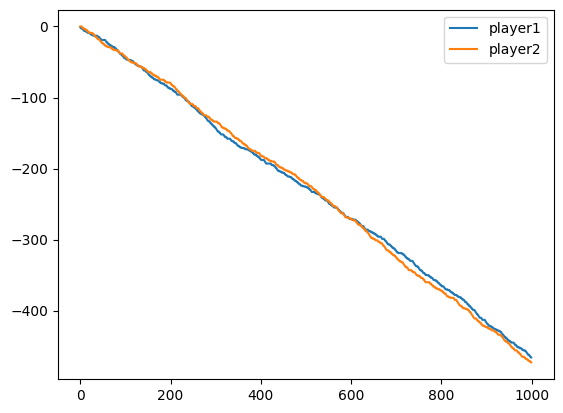

In [24]:
#@title Training
for evolution in range(2):
    print(f"#### Evolution {evolution+1}")
    result = offpolicy_trainer(
        policy=train_policies,
        train_collector=train_collector,
        test_collector=test_collector,
        max_epoch=20,
        step_per_epoch=1000,
        step_per_collect=50,
        episode_per_test=100,
        batch_size=64,
        train_fn=train_fn,
        test_fn=test_fn,
        stop_fn=stop_fn,
        save_best_fn=save_best_fn,
        update_per_step=0.1,
        test_in_train=False,
        reward_metric=reward_metric,
        logger=logger
    )

    model_save_path2 = os.path.join("log", "hommul", "dqn", "policy2.pth")
    if not hasattr(train_policies.policies[agents[0]], 'nolearn'):
        train_policies.policies[agents[0]].load_state_dict(torch.load(model_save_path2))
        train_policies.policies[agents[1]].load_state_dict(torch.load(model_save_path2))

    result = test_collector.collect(n_episode=1000)
    arr = result["rews"]
    interval_size = 100
    num_intervals = episodes // interval_size

    means = []
    std_devs = []

    for i in range(0, episodes, interval_size):
        interval_data = arr[i:i+interval_size]
        mean = np.mean(interval_data, axis=0)
        means.append(mean)

    for i in range(num_intervals - 1):
        mean_diff = means[i+1] - means[i]
        std_devs.append(mean_diff)

    avg = (np.mean(arr, axis=0)) * -100
    std_dev = np.std(std_devs, axis=0) * 100

    print("#"*10)
    print()
    print(f"death rate (in %) of player1: {avg[0]:.1f} +- {std_dev[0]:.3f}")
    print(f"death rate (in %) of player2: {avg[1]:.1f} +- {std_dev[1]:.3f}")
    plt.plot(arr.cumsum(axis=0))
    plt.legend(("player1", "player2"))
    plt.show()

    print()

In [25]:
from itertools import product

algos = [AlwaysPlay(), AlwaysWait(), HailMary(), RandomAgent(), agent_learn2]
df = []

for algo1, algo2 in product(algos, repeat=2):
    test_policies = MultiAgentPolicyManager([algo1, algo2],  _get_env_test())
    test_collector = Collector(test_policies, test_envs, exploration_noise=True)
    result = test_collector.collect(n_episode=1000)
    arr = result["rews"]
    interval_size = 100
    num_intervals = episodes // interval_size

    means = []
    std_devs = []

    for i in range(0, episodes, interval_size):
        interval_data = arr[i:i+interval_size]
        mean = np.mean(interval_data, axis=0)
        means.append(mean)

    for i in range(num_intervals - 1):
        mean_diff = means[i+1] - means[i]
        std_devs.append(mean_diff)

    avg = (np.mean(arr, axis=0)) * -100
    std_dev = np.std(std_devs, axis=0) * 100

    df.append([str(algo1).split('(')[0], str(algo2).split('(')[0], avg[0], std_dev[0], avg[1], std_dev[1]])

    print("#"*10)
    print()
    print(f"death rate (in %) of {str(algo1).split('(')[0]} as player1: {avg[0]:.1f} +- {std_dev[0]:.3f}")
    print(f"death rate (in %) of {str(algo2).split('(')[0]} as player2: {avg[1]:.1f} +- {std_dev[1]:.3f}")

    print()

##########

death rate (in %) of AlwaysPlay as player1: 35.3 +- 7.305
death rate (in %) of AlwaysPlay as player2: 32.7 +- 3.392

##########

death rate (in %) of AlwaysPlay as player1: 64.9 +- 6.600
death rate (in %) of AlwaysWait as player2: -0.0 +- 0.000

##########

death rate (in %) of AlwaysPlay as player1: 59.4 +- 4.422
death rate (in %) of HailMary as player2: 23.3 +- 3.333

##########

death rate (in %) of AlwaysPlay as player1: 53.4 +- 11.827
death rate (in %) of RandomAgent as player2: 18.8 +- 6.164

##########

death rate (in %) of AlwaysPlay as player1: 64.0 +- 5.801
death rate (in %) of DQNPolicy as player2: 0.2 +- 0.667

##########

death rate (in %) of AlwaysWait as player1: -0.0 +- 0.000
death rate (in %) of AlwaysPlay as player2: 65.9 +- 3.957

##########

death rate (in %) of AlwaysWait as player1: 48.5 +- 6.327
death rate (in %) of AlwaysWait as player2: 50.5 +- 8.171

##########

death rate (in %) of AlwaysWait as player1: 25.7 +- 5.230
death rate (in %) of HailMary

In [26]:
df = pd.DataFrame(df, columns=["player1_name", "player2_name", "player1_mean_death_rate", "player1_std_dev_death_rate", "player2_mean_death_rate", "player2_std_dev_death_rate"])
df.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,player1_name,player2_name,player1_mean_death_rate,player1_std_dev_death_rate,player2_mean_death_rate,player2_std_dev_death_rate
0,AlwaysPlay,AlwaysPlay,35.3,7.304658,32.7,3.392075
1,AlwaysPlay,AlwaysWait,64.9,6.599663,-0.0,0.000000
2,AlwaysPlay,HailMary,59.4,4.422166,23.3,3.333333
3,AlwaysPlay,RandomAgent,53.4,11.826941,18.8,6.164414
4,AlwaysPlay,DQNPolicy,64.0,5.801234,0.2,0.666667


In [27]:
for idx, group in df.groupby("player1_name"):
    group = group.loc[~(group.player1_name == group.player2_name)]
    wins = (group.player1_mean_death_rate < group.player2_mean_death_rate).sum()
    print(idx, wins)

AlwaysPlay 0
AlwaysWait 3
DQNPolicy 3
HailMary 2
RandomAgent 1


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [28]:
arr = [str(tuple(np.around(x, 2))) for x in df[["player1_mean_death_rate", "player2_mean_death_rate"]].values]
arr = np.reshape(arr, (5, 5))
arr

pd.DataFrame(arr, columns=df.player1_name.unique(), index=df.player1_name.unique())


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,AlwaysPlay,AlwaysWait,HailMary,RandomAgent,DQNPolicy
AlwaysPlay,"(35.3, 32.7)","(64.9, -0.0)","(59.4, 23.3)","(53.4, 18.8)","(64.0, 0.2)"
AlwaysWait,"(-0.0, 65.9)","(48.5, 50.5)","(25.7, 39.8)","(23.5, 58.7)","(52.1, 49.3)"
HailMary,"(9.8, 66.1)","(57.1, 5.1)","(44.6, 36.9)","(32.8, 37.7)","(58.2, 7.2)"
RandomAgent,"(15.7, 52.1)","(58.2, 24.5)","(42.5, 30.3)","(35.7, 40.2)","(57.5, 22.5)"
DQNPolicy,"(0.1, 62.9)","(51.2, 50.2)","(29.0, 35.6)","(22.9, 59.1)","(47.6, 47.5)"
